In [1]:
import sys
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import cm

# Custom package
sys.path.append('/home/rrp000/sea_ice/code/')
from icepack import get_dataset
from icepack.analysis import *
from icepack.splot import *

# Some useful lists and dicts
monthletters = ['J','F','M','A','M','J','J','A','S','O','N','D']
monthstr = ['01','02','03','04','05','06','07','08','09','10','11','12']
monthdict = {1:r'$\mathbf{January}$',
             2:r'$\mathbf{February}$',
             3:r'$\mathbf{March}$',
             4:r'$\mathbf{April}$',
             5:r'$\mathbf{May}$',
             6:r'$\mathbf{June}$',
             7:r'$\mathbf{July}$',
             8:r'$\mathbf{August}$',
             9:r'$\mathbf{September}$',
             10:r'$\mathbf{October}$',
             11:r'$\mathbf{November}$',
             12:r'$\mathbf{December}$'}
mask = xr.open_dataset("~/sea_ice/data/masks/land_all.nc")


In [2]:
method = 'mean'
daterange_clim = (2016,2016)

#### daily obs

In [3]:
sic_path = "~/sea_ice/data/obs/Had2CIS/sic/1x1/td_hadisst2.2_cis_great_cmc_monthly_cdo360x180_195901_202412_sicn.nc"
grid_path = "~/sea_ice/data/grids/grid_1x1.nc"

# open data
sic_Had2CIS = format_time_coord(xr.open_dataset(sic_path),'1959-01','2024-12',freq='M')
print(sic_Had2CIS)
sic_Had2CIS['time'] = sic_Had2CIS['time'] + np.timedelta64(14,'D')
sic_Had2CIS_dailyint = sic_Had2CIS.copy(deep=True)

# interpolated daily Had2CIS
m = '01'; nd = 31

print('Selecting temporal range')
# sic_Had2CIS_dailyint = sic_Had2CIS_dailyint.where((sic_Had2CIS_dailyint['time.year'] >= yr-1)&(sic_Had2CIS_dailyint['time.year'] <= yr+1), drop=True)
sic_Had2CIS_dailyint = sic_Had2CIS_dailyint.where((sic_Had2CIS_dailyint['time.year'] >= daterange_clim[0]-1)&(sic_Had2CIS_dailyint['time.year'] <= daterange_clim[1]+1), drop=True)
print('Applying mask')
sic_Had2CIS_dailyint = apply_mask(sic_Had2CIS_dailyint,'sicn',mask)
print('Resampling')
sic_Had2CIS_dailyint = sic_Had2CIS_dailyint.resample(time='1D').interpolate('linear')
print('Calculating ice extent')
sic_Had2CIS_dailyint = sic_Had2CIS_dailyint.where((sic_Had2CIS_dailyint['time.month']==int(m)),drop=True).where((sic_Had2CIS_dailyint['time.year'] >= daterange_clim[0])&(sic_Had2CIS_dailyint['time.year'] <= daterange_clim[1]), drop=True)
sia_Had2CIS_dailyint = get_icearea(sic_Had2CIS_dailyint, mask, lat_bounds=(-90,0), ensemble=None)#.groupby('time.day').mean('time')
sie_Had2CIS_dailyint = get_iceextent(sic_Had2CIS_dailyint, mask, lat_bounds=(-90,0), ensemble=None)#.groupby('time.day').mean('time')

<xarray.Dataset> Size: 205MB
Dimensions:  (time: 792, lon: 360, lat: 180)
Coordinates:
  * time     (time) datetime64[ns] 6kB 1959-01-01 1959-02-01 ... 2024-12-01
  * lon      (lon) float64 3kB 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
Data variables:
    sicn     (time, lat, lon) float32 205MB ...
Attributes:
    CDI:                 Climate Data Interface version 2.4.0 (https://mpimet...
    Conventions:         CF-1.6
    title:               Converted from CCCma format
    CCCma_file:          td_hadisst2.2_cis_great_cmc_monthly_360x180_195901_2...
    history:             Mon Jun 10 19:35:40 2024: cdo remapbil,r360x180 td_h...
    CCCma_data_licence:  1) GRANT OF LICENCE - The Government of Canada  (Env...
    CDO:                 Climate Data Operators version 2.4.0 (https://mpimet...
Selecting temporal range
Applying mask
Resampling
Calculating ice extent


### GEM5.2NEMO

In [4]:
# print('opening data')
# # open data and format time
# sic_GEM5NEMO_init = xr.open_dataset(f"/home/rrp000/sea_ice/data/model/GEM5v2-NEMO/c3s_init/sic/nat/{m}/cwao_GEM5.2-NEMO-v20240611_hindcast_SALL{m}0100_seaIce_day_surface_sic_rALLi00p00.nc")
# sic_GEM5NEMO_init = sic_GEM5NEMO_init.where(sic_GEM5NEMO_init['time.month']==int(m),drop=True).where(sic_GEM5NEMO_init['time.year']>=daterange_clim[0],drop=True).where(sic_GEM5NEMO_init['time.year']<=daterange_clim[1],drop=True)#.interp(lon=mask['lon'],lat=mask['lat'],method='nearest').where(~np.isnan(mask['mask']),other=np.nan)
# sie_GEM5NEMO_init = get_iceextent(sic_GEM5NEMO_init, mask, lat_bounds=(-90,0), ensemble='mean').groupby('time.day').mean('time')
# sia_GEM5NEMO_init = get_icearea(sic_GEM5NEMO_init, mask, lat_bounds=(-90,0), ensemble='mean').groupby('time.day').mean('time')

In [5]:
sic_CanESM5_w_all = [xr.open_dataset(f"/home/rrp000/sea_ice/data/model/CanESM5/v1/nudge+init/day/winds_20160101-20161231/sic/1x1/siconc_SIday_CanESM5-c3bnw2-201601e0{e}_dcppA-hindcast_s2015-r{e}i1p2f1_gn_20160101-20161231.nc") for e in np.arange(1,2)]
sic_CanESM5_wt_all = [xr.open_dataset(f"/home/rrp000/sea_ice/data/model/CanESM5/v1/nudge+init/day/winds+temp_20160101-20161231/sic/1x1/siconc_SIday_CanESM5-c3bnwt2-201601e0{e}_dcppA-hindcast_s2015-r{e}i1p2f1_gn_20160101-20161231.nc") for e in np.arange(1,2)]

sic_CanESM5_w = apply_mask(xr.concat(sic_CanESM5_w_all,dim='ensemble'),'siconc',mask,)
sic_CanESM5_wt = apply_mask(xr.concat(sic_CanESM5_wt_all,dim='ensemble'),'siconc',mask)

sie_CanESM5_w = get_iceextent(sic_CanESM5_w, mask, lat_bounds=(-90,0),ensemble='mean',multiply_input_by=1e-2)
sie_CanESM5_wt = get_iceextent(sic_CanESM5_wt, mask, lat_bounds=(-90,0),ensemble='mean',multiply_input_by=1e-2)

sia_CanESM5_w = get_icearea(sic_CanESM5_w, mask, lat_bounds=(-90,0),ensemble='mean',multiply_input_by=1e-2)
sia_CanESM5_wt = get_icearea(sic_CanESM5_wt, mask, lat_bounds=(-90,0),ensemble='mean',multiply_input_by=1e-2)

# Plots

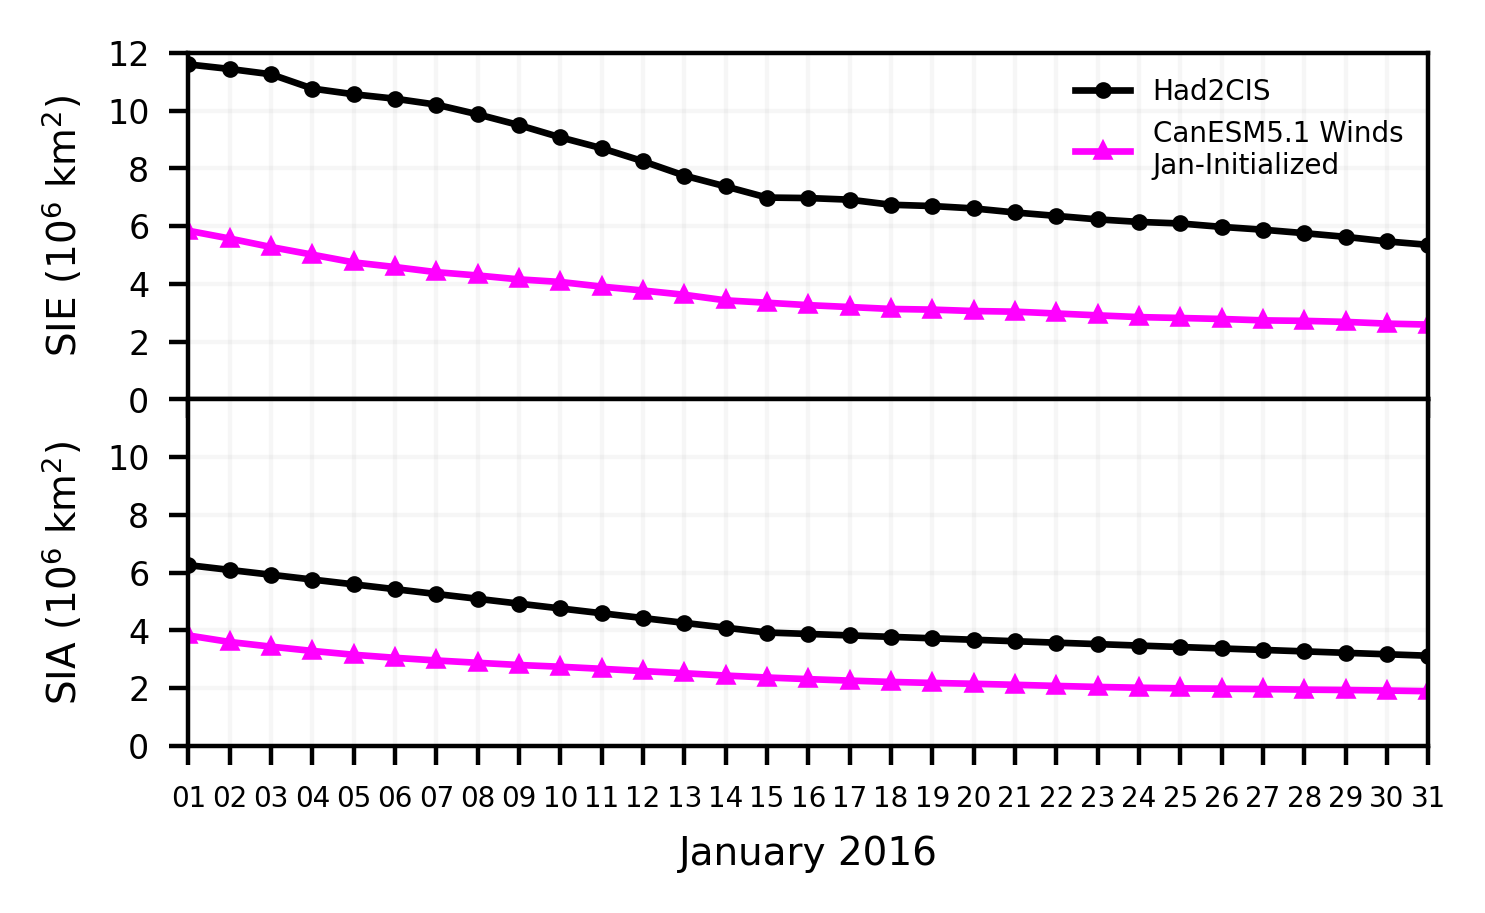

In [10]:
fix,ax=plt.subplots(2,1,figsize=(4,2.25),dpi=400, sharex=True)

# The data to be plotted. Labels for legend are defined in a previous cell.
timeseries = [sie_Had2CIS_dailyint,sie_CanESM5_w,sie_CanESM5_wt]
xticklabels = ['J','F','M','A','M','J','J','A','S','O','N','D']
colors = ['black','grey','blue']
labels = ['Had2CIS','CanESM5.1 Winds\nJan-Initialized','CanESM5.1 Winds+Temp']
linestyles = ['-','-','-']
markers=['o','^','^']

# Plot the data
ax[0].plot(sie_Had2CIS_dailyint.isel({'time':np.arange(31)})['SIE'].values,color='black',marker='o',ms=2,lw=1.2)
ax[0].plot(sie_CanESM5_w.isel({'time':np.arange(31)})['SIE'].values,color='magenta',marker='^',ms=2,lw=1.2)
ax[0].set_ylim(0,12.)
ax[0].set_yticks(np.arange(0,14,2))
ax[0].set_yticklabels(np.arange(0,14,2),size=6)
ax[0].set_xlim(0,30)
xlabels = ["0"+str(i) for i in np.arange(1,9+1,1)] + list(np.arange(10,nd+1,1))
ax[0].set_xticks(np.arange(0,nd))
ax[0].set_xticklabels(xlabels,size=5)
ax[0].set_xlabel(f"January 2016",size=7)
ax[0].set_ylabel(r"SIE ($10^6\ \mathrm{km}^2$)", size=7)
ax[0].set_title(None)
ax[0].grid(alpha=0.1)
ax[0].legend(labels,fontsize=5,frameon=False,loc='upper right',ncols=1)

ax[1].plot(sia_Had2CIS_dailyint.isel({'time':np.arange(31)})['SIA'].values,color='black',marker='o',ms=2,lw=1.2)
ax[1].plot(sia_CanESM5_w.isel({'time':np.arange(31)})['SIA'].values,color='magenta',marker='^',ms=2,lw=1.2)
ax[1].set_ylim(0,12)
ax[1].set_yticks(np.arange(0,12,2))
ax[1].set_yticklabels(np.arange(0,12,2),size=6)
ax[1].set_xlim(0,30)
xlabels = ["0"+str(i) for i in np.arange(1,9+1,1)] + list(np.arange(10,nd+1,1))
ax[1].set_xticks(np.arange(0,nd))
ax[1].set_xticklabels(xlabels,size=5)
ax[1].set_xlabel(f"January 2016",size=7)
ax[1].set_ylabel(r"SIA ($10^6\ \mathrm{km}^2$)", size=7)
ax[1].set_title(None)
ax[1].grid(alpha=0.1)
# ax[1].legend(labels,fontsize=6,frameon=False,loc='upper right',ncols=1)

plt.subplots_adjust(hspace=0)
plt.show()

In [8]:
# fix,ax=plt.subplots(2,1,figsize=(4,2.25),dpi=200,sharex=True)

# # The data to be plotted. Labels for legend are defined in a previous cell.
# timeseries = [sia_Had2CIS_dailyint,sia_GEM5NEMO_init]#,np.abs(sia_Had2CIS_dailyint-sia_GEM5NEMO_init)]
# timeseries2 = [sie_Had2CIS_dailyint,sie_GEM5NEMO_init]#,np.abs(sie_Had2CIS_dailyint-sie_GEM5NEMO_init)]
# xticklabels = ['J','F','M','A','M','J','J','A','S','O','N','D']
# colors = ['black','magenta','blue']
# labels = ['Had2CIS','GEM5.2-NEMO','Difference']
# linestyles = ['-','-',':']
# markers=['o','^',None]

# # Plot the data
# for i,data in enumerate(timeseries2):
#     data['SIE'].plot.line(ax=ax[0],color=colors[i],label=labels[i],linestyle=linestyles[i],lw=1,marker=markers[i],ms=1.7)
# ax[0].set_ylim(10,21)
# ax[0].set_yticks(np.arange(10,22+2,2))
# ax[0].set_yticklabels(np.arange(10,22+2,2),size=6)
# xlabels = ["0"+str(i) for i in np.arange(1,9+1,1)] + list(np.arange(10,nd+1,1))
# ax[0].set_xlim(1,30)
# ax[0].set_xticks(np.arange(1,nd+1))
# ax[0].set_xticklabels(xlabels,size=5)
# ax[0].set_xlabel(f"{monthdict[int(m)]} Clim. ({daterange_clim[0]}-{daterange_clim[1]})",size=7)
# ax[0].set_ylabel(r"SIE ($10^6\ \mathrm{km}^2$)", size=7)
# ax[0].set_title(None)
# ax[0].grid(alpha=0.1)
# ax[0].legend(labels,fontsize=5,frameon=False,ncols=1,loc='lower right')

# for i,data in enumerate(timeseries):
#     data['SIA'].plot.line(ax=ax[1],color=colors[i],label=labels[i],linestyle=linestyles[i],lw=1,marker=markers[i],ms=1.7)
# ax[1].set_ylim(10,22)
# ax[1].set_yticks(np.arange(10,22,2))
# ax[1].set_yticklabels(np.arange(10,22,2),size=6)
# xlabels = ["0"+str(i) for i in np.arange(1,9+1,1)] + list(np.arange(10,nd+1,1))
# ax[1].set_xlim(1,30)
# ax[1].set_xticks(np.arange(1,nd+1))
# ax[1].set_xticklabels(xlabels,size=5)
# # ax[1].set_xlabel(f"{monthdict[int(m)]} Clim. ({daterange_clim[0]}-{daterange_clim[1]})",size=7)
# ax[1].set_xlabel("October",size=7)
# ax[1].set_ylabel(r"SIA ($10^6\ \mathrm{km}^2$)", size=7)
# ax[1].set_title(None)
# ax[1].grid(alpha=0.1)
# # ax[1].legend(labels,fontsize=5,frameon=False,ncols=1)

# plt.subplots_adjust(hspace=0)
# plt.show()

In [ ]:
# fix,ax=plt.subplots(1,1,figsize=(5,3),dpi=200)

# # The data to be plotted, the years over which to plot, labels for legend, etc.
# timeseries = [sie_Had2CIS_dailyint, sie_Had2CIS_dailyint, sie_GEM5NEMO_init]
# colors = ['black','grey','orange','blue','purple']
# linestyles = ['-','-','--',':',':']
# labels = ['Had2CIS (Interpolated)',f'GEM5.2-NEMO {monthdict[int(m)]}-Init','Difference']

# # Plot the data
# for i,data in enumerate(timeseries):
#     data.where((data['time.year']==yr) & (data['time.month']==int(m)),drop=True)['SIA'].plot.line(ax=ax,color=colors[i],linestyle=linestyles[i],linewidth=1.3)
#     # data['SIA'].plot.line(ax=ax,color=colors[i],linestyle=linestyles[i],linewidth=1.3)

# # Other details of the plots
# xlabels = ["0"+str(i) for i in np.arange(1,9+1,1)] + list(np.arange(10,nd+1,1))
# ax.set_xticks(np.arange(1,nd+1))
# ax.set_xticklabels(xlabels,size=5)
# ax.set_xlabel(f"{monthdict[int(m)]} Clim. ({daterange_clim[0]}-{daterange_clim[1]})")
# ax.set_ylim(0,21.5)
# ax.set_yticks(np.arange(0,22))
# ax.set_yticklabels(np.arange(0,22),size=6)
# ax.set_ylabel(r"SIA ($10^6\ \mathrm{km}^2$)")
# ax.set_title("SH Sea Ice Area")
# ax.grid(alpha=0.1)
# ax.legend(labels,fontsize=7,frameon=False,loc='right')
# plt.show()

In [ ]:
# fig, ax = plt.subplots(ncols=2,nrows=1,figsize=(4,4),facecolor='white',dpi=400,sharey=True,subplot_kw={'projection':ccrs.Orthographic(central_latitude=-90., central_longitude=0.0)})

# sic_Had2CIS_daily['sicn'] = sic_Had2CIS_daily['sic']
# sic_plot = add_sic(ax[0], sic_Had2CIS_dailyint.resample(time='ME').mean().groupby('time.month').mean(), anom=False, month=9)
# add_sic(ax[1], sic_Had2CIS_daily.resample(time='ME').mean().groupby('time.month').mean(), anom=False, month=9)
# sic_plot.set_clim([0., 1.])
# plt.subplots_adjust(wspace=.02)
# set_extent(ax[0])
# set_extent(ax[1])
# ax[0].coastlines()
# ax[1].coastlines()
# ax[0].set_title("Had2CIS",size=6)
# ax[1].set_title("HadISST.2.2",size=6)
# cticks = np.linspace(0.,1.,11)
# cbar = plt.colorbar(sic_plot,ax=ax,aspect=75,shrink=1,ticks=cticks,location='bottom',pad=0.02)
# cbar.ax.tick_params(labelsize=5)
# cbar.ax.set_title(r"$\mathbf{SIC}$",fontsize=5,y=-8.)

# plt.show()

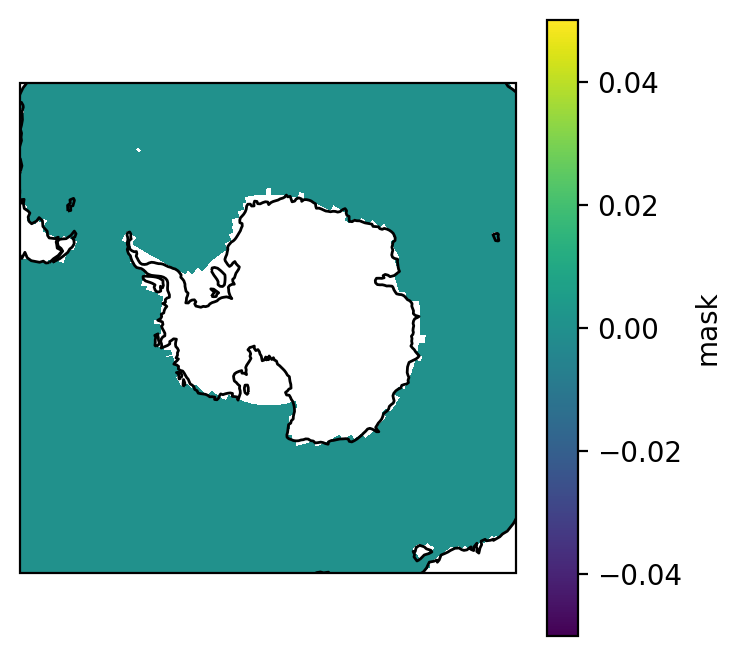

In [ ]:
fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(4,4),facecolor='white',dpi=200,sharey=True,subplot_kw={'projection':ccrs.Orthographic(central_latitude=-90., central_longitude=0.0)})

set_extent(ax)
ax.coastlines()

mask['mask'].plot(ax=ax,transform=ccrs.PlateCarree())

plt.show()

NameError: name 'sic_CanESM5_w' is not defined

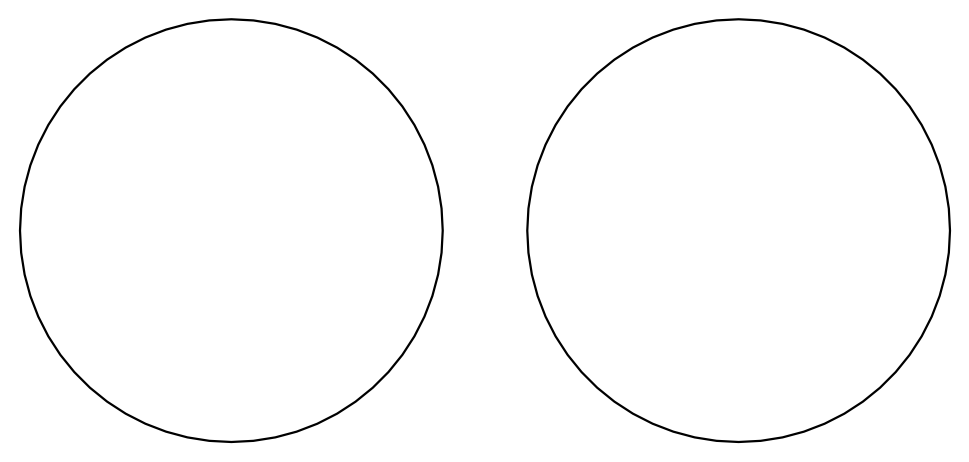

In [ ]:
ncols=2
nrows=1 # i.e., number of days
fig, ax = plt.subplots(ncols=ncols,nrows=nrows,figsize=(6,6),facecolor='white',dpi=200,squeeze=False,subplot_kw={'projection':ccrs.Orthographic(central_latitude=-90., central_longitude=0.0)})

datasets = [[sic_Had2CIS_dailyint],[1e-2*sic_CanESM5_w.mean(dim='ensemble')]]
names = ["Had2CIS\n(Interpolated)","CanESM5.0\nWinds-Nudged"]

# add_ice_edge(ax[0][0],sic_Had2CIS_dailyint.resample(time='M').mean(), month=1, year=2016)
# add_ice_edge(ax[0][1],sic_CanESM5_w.mean(dim='ensemble').resample(time='M').mean(), month=1, year=2016)

# add_ice_edge(ax[0][0],sic_Had2CIS, month=1, year=2016)
set_extent(ax[0][0],domain=[-180,180,-90,-55])
ax[0][0].coastlines()
sic_plot=add_sic(ax[0][0], datasets[0][0], anom=False, month=1, year=2016, day=1)
ax[0][0].set_title(None)
set_extent(ax[0][1],domain=[-180,180,-90,-55])
ax[0][1].coastlines()
sic_plot2=add_sic(ax[0][1], datasets[1][0], anom=False, month=1, year=2016, day=1)
ax[0][1].set_title(None)
plt.subplots_adjust(wspace=0,hspace=0)
sic_plot.set_clim([0., 1.])
sic_plot2.set_clim([0., 1.])
cticks = np.linspace(0.,1.,11)
cbar = plt.colorbar(sic_plot,ax=ax,shrink=1,aspect=75,ticks=cticks,location='bottom',pad=0.01)#,label=r"$\mathbf{SIC}$")
#plt.tight_layout()
cbar.ax.tick_params(labelsize=7)
cbar.ax.set_xlabel(r"$\mathbf{SIC}$",fontsize=7,loc='center')
ax[0][0].text(-49,-45,r'$\bf{(a)}$',transform=ccrs.PlateCarree())
ax[0][1].text(-49,-45,r'$\bf{(b)}$',transform=ccrs.PlateCarree())

lon_marks=np.linspace(0,360-(360/6),6)
# for l in lon_marks:
#     ax[0][0].plot([l,l],[-90,0],color='black',alpha=0.1,lw=1,transform=ccrs.PlateCarree())
#     ax[0][1].plot([l,l],[-90,0],color='black',alpha=0.1,lw=1,transform=ccrs.PlateCarree())
    # ax[0][1].text(l,-57,l,color='black',size=4,transform=ccrs.PlateCarree())

# ax[0][1].plot([0,40],[-65,-65],color='black',alpha=0.1,lw=1,transform=ccrs.PlateCarree())


plt.show()

In [ ]:
# ncols=2
# nrows=6 # i.e., number of days
# fig, ax = plt.subplots(ncols=ncols,nrows=nrows,figsize=(4,12),facecolor='white',dpi=150,subplot_kw={'projection':ccrs.Orthographic(central_latitude=-90., central_longitude=0.0)})

# datasets = [[sic_Had2CIS_daily],[sic_CanESM5_wn2016_init_daily.mean(dim='ensemble')]]
# names = ["Had2CIS (Interpolated)","CanESM5.1 Wind-Nudge J-init"]
# for i in np.arange(ncols): # dataset
#     data = datasets[i]
#     for j in np.arange(nrows): # days 
#         d = 6*j+1
#         set_extent(ax[j][i],domain=[-180,180,-90,-55])
#         ax[j][i].coastlines()
#         add_sic(ax[j][i], data[0], anom=False, month=1, year=2016, day=d)
#         add_ice_edge(ax[j][i], sic_clim_Had2CIS, month=1)
#         if j == 0:
#             ax[j][i].set_title(f"{names[i]}\n{monthdict[1]} {d}, 2016", size=8)
#         else:
#             ax[j][i].set_title(f"{monthdict[1]} {d}, 2016", size=8)

# #plt.tight_layout()
# plt.show()

In [ ]:
# ncols=2
# nrows=6 # i.e., number of days
# fig, ax = plt.subplots(ncols=ncols,nrows=nrows,figsize=(4,12),facecolor='white',dpi=150,subplot_kw={'projection':ccrs.Orthographic(central_latitude=-90., central_longitude=0.0)})

# datasets = [[sic_Had2CIS_daily],[sic_CanESM5_wn2016_init_daily.mean(dim='ensemble')]]
# names = ["Observation","CanESM5 Wind-Nudge J-init"]
# for i in np.arange(ncols): # dataset
#     data = datasets[i]
#     for j in np.arange(nrows): # days 
#         d = 5*j+1
#         set_extent(ax[j][i],domain=[-180,180,-90,-55])
#         ax[j][i].coastlines()
#         #add_psl(ax[j][i], data[1], month=2, year=2016, day=d)
#         add_sic(ax[j][i], data[0], anom=False, month=2, year=2016, day=d)
#         add_ice_edge(ax[j][i], sic_clim_Had2CIS, month=2)
#         if j == 0:
#             ax[j][i].set_title(f"{names[i]}\n{monthdict[2]} {d}, 2016", size=8)
#         else:
#             ax[j][i].set_title(f"{monthdict[2]} {d}, 2016", size=8)

# plt.tight_layout()
# plt.show()

In [ ]:
# ncols=3
# nrows=6 # i.e., number of days
# fig, ax = plt.subplots(ncols=ncols,nrows=nrows,figsize=(6,12),facecolor='white',dpi=150,subplot_kw={'projection':ccrs.Orthographic(central_latitude=-90., central_longitude=0.0)})

# datasets = [[sic_Had2CIS_daily],[sic_CanESM5_wn2016_init_daily.mean(dim='ensemble')],[sic_CanESM5_wtn2016_init_daily.mean(dim='ensemble')]]
# names = ["Had2CIS Interpolated","CanESM5 Wind-Nudge J-init","CanESM5 WindTemp-Nudge J-init"]
# for i in np.arange(ncols): # dataset
#     data = datasets[i]
#     for j in np.arange(nrows): # days 
#         d = 5*j+1
#         set_extent(ax[j][i],domain=[-180,180,-90,-55])
#         ax[j][i].coastlines()
#         #add_psl(ax[j][i], data[1], month=11, year=2016, day=d)
#         add_sic(ax[j][i], data[0], anom=False, month=11, year=2016, day=d)
#         add_ice_edge(ax[j][i], sic_clim_Had2CIS, month=11)
#         ax[j][i].set_title(f"{names[i]}\n{monthdict[11]} {d} 2016", size=8)

# plt.tight_layout()
# plt.show()